# Лабораторная работа №1.1 "Экспериментальная проверка уравнения Эйнштейна для фотоэффекта и определение постоянной Планка"

В работе исследуется зависимость фототока от величины задерживающего потенциала и частоты падающего излучения, что позволяет вычислить величину постоянной Планка.

Уравнение Эйнштейна:
\begin{equation}
\label{eq1}
\hbar \omega = E_{\text{max}} + W
\end{equation}
где $E_{\text{max}}$ - максимальная кинетическая энергия электрона после выхода из фотокатода, $W$ - работа выхода электрона из катода.

Из описания имеем формулу для полного числа частиц:
\begin{equation}
\label{eq2}
N(\nu) = 2\pi n_0 \left[ \dfrac{\nu_0^2}{4} - \left(\dfrac{1 - V/V_0}{\nu_0} - \dfrac{\nu_0}{2}\right)^2 \right]
\end{equation}
Корень квадратный из фототока линейно зависит от запирающего напряжения.

### Калибровочный график

In [1]:
import pandas as pd

CALIBRATION_DATA_PATH = './calibration.csv'
LAMP_DATA_PATH = './all_data.csv'
df_calibration = pd.read_csv(CALIBRATION_DATA_PATH, sep=';', dtype=float)
df_calibration.head()

,lambda,angle
0,5341.0,1830.0
1,5401.0,1878.0
2,5852.0,2140.0
3,5882.0,2150.0
4,5945.0,2180.0


Посмотрим, является ли калибровочный график прямой

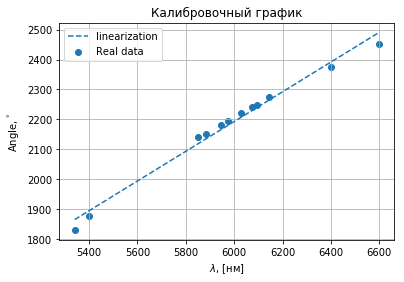

In [3]:
import matplotlib.pyplot as plt

x, y = df_calibration['lambda'], df_calibration['angle']
plt.scatter(df_calibration['lambda'], df_calibration['angle'], label='Real data')

# Аппроксимация
from scipy.stats import linregress
calibration_slope, calibration_intercept, r_value, p_value, std_err = linregress(x,y)
plt.plot(x, calibration_slope*x+calibration_intercept, '--', label='linearization')

plt.xlabel('$\lambda$, [нм]')
plt.ylabel('Angle, $^\degree$')
plt.grid()
plt.legend()
plt.title(r'Калибровочный график')

plt.show()

Видно, что в середине диапазона калибровочной график хорошо описывается прямой. Это нам пригодится в будущем, а пока сделаем функцию для перевода угла в длину волны

In [4]:
angle_to_lambda = lambda angle: calibration_slope*angle + calibration_intercept

### Информация с лампы

In [29]:
df_lamp = pd.read_csv(LAMP_DATA_PATH, sep=';', dtype=float)
df_lamp.head()

,angle,V,I
0,1850.0,5.440,0.517
1,1850.0,4.910,0.508
2,1850.0,4.412,0.501
3,1850.0,3.915,0.491
4,1850.0,3.409,0.478


In [30]:
angles = pd.unique(df_lamp['angle'])

На самом деле, в столбце $I$ находится не сам $I$, а напряжение, пропорциональное $I$. Но для нас это не важно, так как в этой работе мы интересуемся только напряжением запирания. **Поэтому будем дальше писать $I$ вместо $U$.**

Из уравнения выше следует, что нам надо строить график зависимости $V = V(\sqrt{I})$.

#### Угол $1850˚$

In [235]:
from sklearn.base import BaseEstimator
class SigmoidRegressor(BaseEstimator):
    
    def __init__(self, function):
        self.func = function
        
    def fit(self, x_data, y_data):
        scX, scY = StandardScaler(), StandardScaler()
        x_fit = scX.fit_transform(np.array(x_data).reshape(-1, 1)).reshape(1, -1)[0]
        y_fit = scY.fit_transform(np.array(y_data).reshape(-1, 1)).reshape(1, -1)[0]
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(func, x_fit, y_fit)
        opt_func = lambda x: scY.inverse_transform(func(
            scX.transform(np.array(x).reshape(-1, 1)), 
            *popt)).reshape(1, -1)[0]
        self.scX, self.scY, self.opt_func = scX, scY, opt_func
        return self
        
    def predict(self, x_data):
        return self.opt_func(x_data)

In [245]:
def handle_angle(angle, fig=None, axes=None):
    import numpy as np
    import scipy as sc
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(figsize=(16, 9))

    # Отберем нужный угол из глобального датасета
    subset = df_lamp[df_lamp['angle'] == angle]

    # Подсчитаем квадрат (как в лабнике)
    y, x = subset['I']**2, subset['V']
    # Нанесем экспериментальные точки
    axes.scatter(x, y, label='experiment')
    
    x_spline = np.linspace(np.min(x), np.max(x), 1000)
    # Попытаемся приблизить сигмоидой
    funcs = [
        lambda x, k, a, b: k/(1+np.exp(-a*x + b)),
        lambda x, k, a, b: k*np.tanh(x - a),
        lambda x, k, a, b: k*np.arctan(x - a),
        lambda x, k, a, b: k*np.acos(x - a)
    ]
    sigmoid_regressor = SigmoidRegressor(funcs[1])
    y_spline = sigmoid_regressor.fit(x, y).predict(x_spline)
    axes.plot(x_spline, y_spline, '--', label=r'Сплайны')

    axes.set_ylabel(r'$\sqrt{I}$')
    axes.set_xlabel(r'$V$')
    axes.grid()
    axes.legend()
    
    fig.savefig('angle-%s.pdf' % angle)
    
    return fig, axes

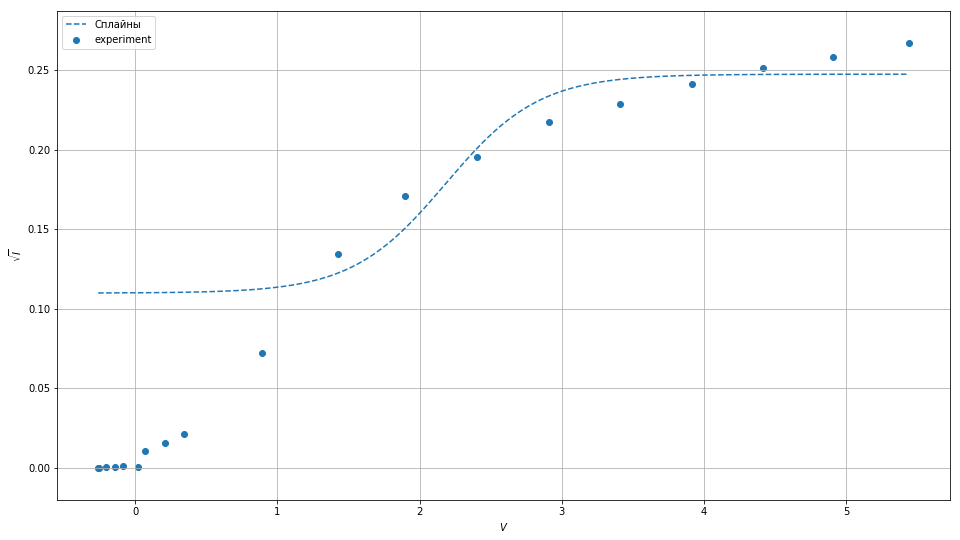

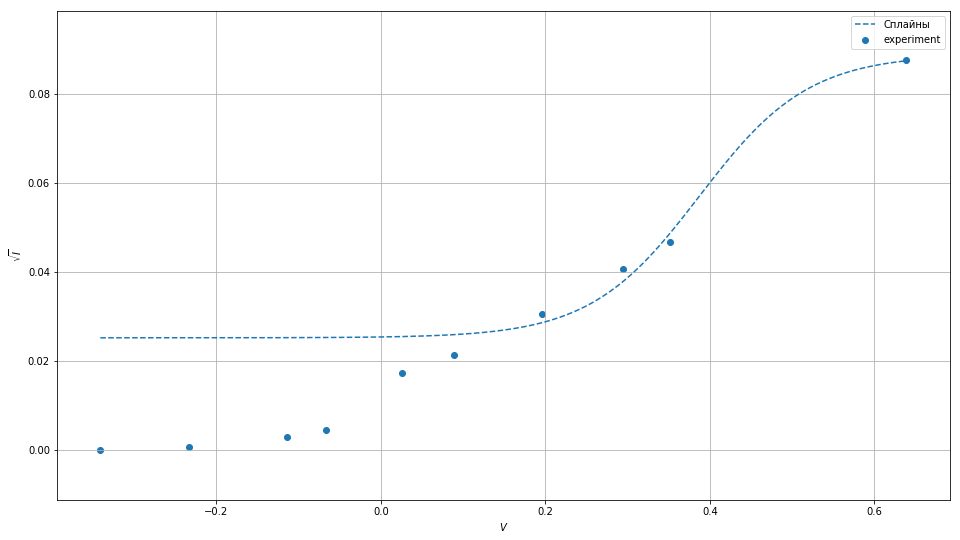

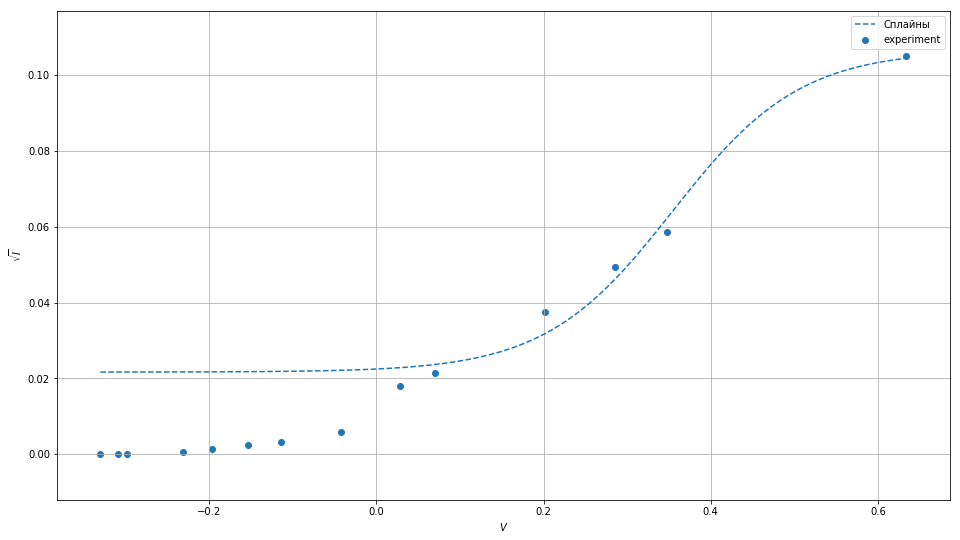

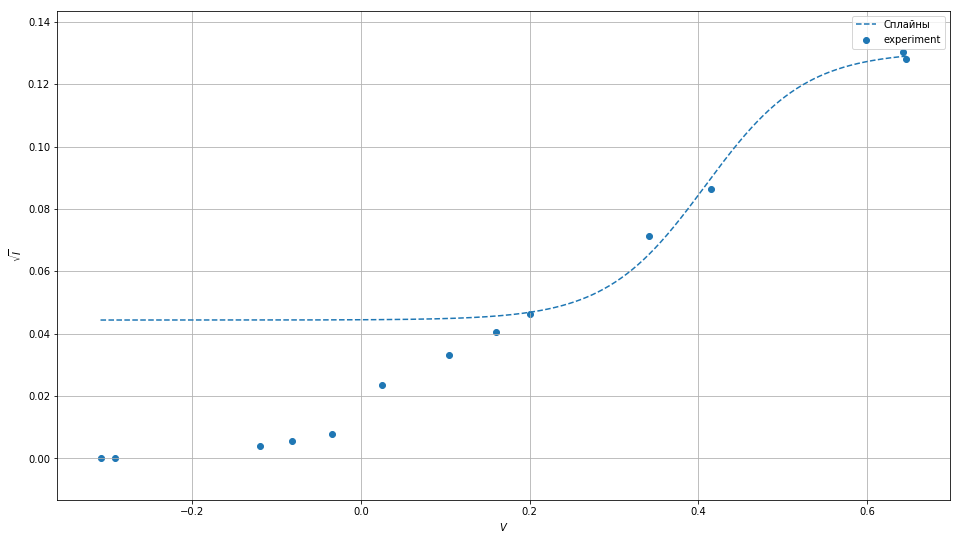

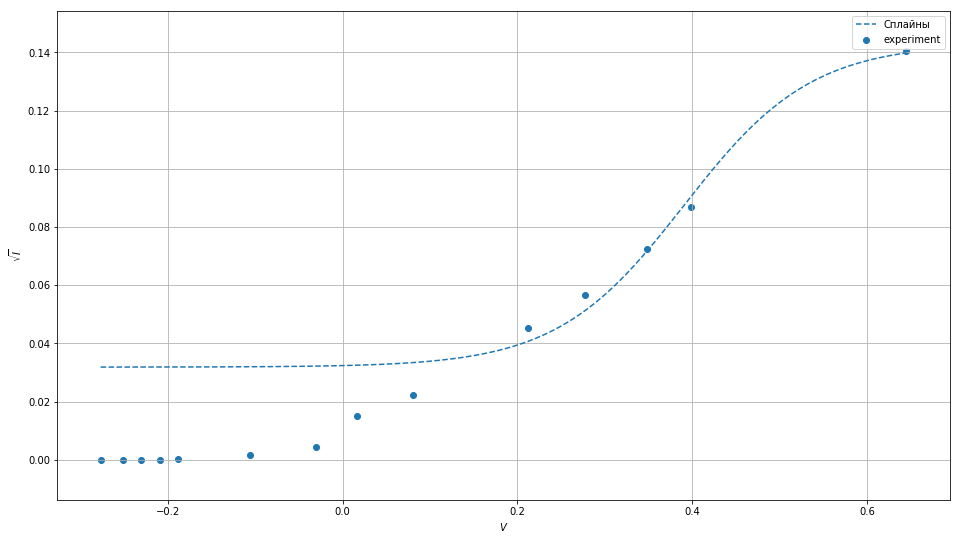

In [246]:
#fig, axes = plt.subplots(figsize=(16, 9))
for angle in angles:
    handle_angle(angle)